# **Feature Engineering From The Titanic Dataset**

Throughout this notebook I will include:

* Creating New Features from Multiple Existing Ones
* One Hot Encoding and Categorical Coding
* Handling Null and NaN Values
* Feature Engineering Using Past Knowledge About the Data
* Mining Features from Text and String Data
* Plotting and Visualizing Each Feature 


# **Importing Libraries And Reading the Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import math

In [2]:
train = pd.read_csv('titanic.csv')

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


As you can see we have very little data to work from. It is our job to expand this dataset and mine the features from it. First, let's get a sense of our Null values, as I can already see a lot of them appearing in the *Cabin* feature.

In [3]:
cols = train.columns
for i in cols:
    print(i, ": ", train[i].isnull().sum())

PassengerId :  0
Survived :  0
Pclass :  0
Name :  0
Sex :  0
Age :  177
SibSp :  0
Parch :  0
Ticket :  0
Fare :  0
Cabin :  687
Embarked :  2


Seems like Embarked and Fares have negligible null values, but Cabin and Age have more signifcant amounts of Null values. We will have to keep this in mind when working with these features. In terms of Cabin, it seems like we are missing around 3/4 of the training data, which is very significant.

# **Passenger Class**

Let's look at our first feature: Pclass. For Passenger Class, there are three options: 1, 2, or 3. One corresponds to the upper, highest class, two corresponds ot the middle class, and three corresponds to the lower, lowest class. 

Text(0, 0.5, 'Number of People')

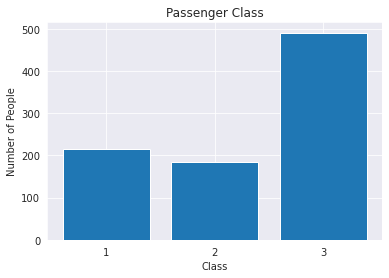

In [4]:
plt.bar([1,2,3], height = [(train.Pclass==1).sum(),(train.Pclass==2).sum(),(train.Pclass==3).sum()])
plt.title('Passenger Class')
plt.xticks([1,2,3])
plt.xlabel('Class')
plt.ylabel('Number of People')

Interestingly, we see more 1st class passengers than 2nd class, as we would expect the amount of people per class to decrease with an increase in class. Yet we still see an overwheleming majority of 3rd class, lower class passengers, which could be significant when training the model. There isn't much to pull from this data, so let's just one-hot encode this data.

One-hot encoding is when you take categorical data and turn it into multiple columns of data. Each column corresponds to one unique element in the categorical data, and each element in that column is a boolean value for whether or not it contains that feature. For example, if a categorical dataset has the options of 1, 2, or 3, a row with the label of '2' will become [0, 1, 0], as 1 and 3 are both False and 2 is True. This is useful for creating larger feature spaces, especailly when training classifiers that rely heavily on independent variables. 

![](https://miro.medium.com/max/1200/0*T5jaa2othYfXZX9W.)

In [5]:
pclass = pd.get_dummies(train.Pclass,prefix = 'Pclass')
train = pd.concat([train,pclass],axis = 1)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1


Awesome! Pclass was an easy feature to handle so a good start so far!

# **Names and Titles**

Here, it gets a little more complicated, as name comes in string data, which we must mine the data from. Let's take a look at what the options are and how the names are formatted.

In [6]:
train.Name.unique()[0:20]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima'], dtype=object)

It seems like most of the names are following the pattern of "LastName, Title. FirstName" with some of them having a parentheses. The second name in the parentheses may mean something else, but we can't tell for sure until we do more digging. But still, there is plenty of data we can pull from just their name. 

First, let's take a look at their title. I will extract the title by finding the index of the comma in the name, adding two to it to get the index of the first letter of the title, and then finding the period. I will then index the string, with the beginning and ending index, to get the titles.

In [7]:
titles = []
for i in range (0,len(train)):
    start = train['Name'][i].find(',') + 2
    end = train['Name'][i].find('.')
    titles.append(train['Name'][i][start:end])
train['Titles'] = titles

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Titles
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,Mr


So now, we have a column of titles, such as Mr, Mrs, and Miss. Let's take a look at all the options for titles.

In [8]:
train.Titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Wow there are some weird ones in there! Who knows what a "jonkheer" is. Let's take a look at the distribution of these titles as well, since some of these are very odd and rare titles.

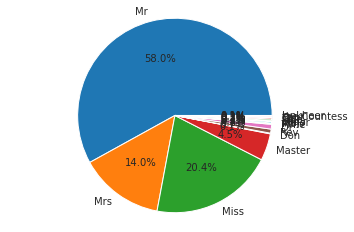

In [9]:
fig1, ax1 = plt.subplots()
sizes = []
for i in train.Titles.unique():
    sizes.append((train.Titles==i).sum())
ax1.pie(sizes, labels = train.Titles.unique(),autopct = '%1.1f%%')
ax1.axis('equal')
plt.show()

It looks like the bulk of titles are either Mr, Mrs, or Miss, which are the standard titles, and the rest are what I will call "special titles". From this, I believe we can make another feature. I will make a boolean feature, where True will indicate that this element is a "special title" whereas False will indicate it is one of the three common titles.

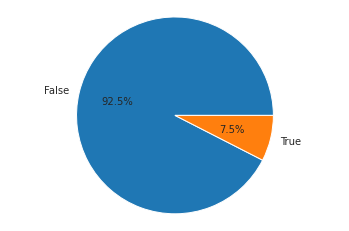

In [10]:
train['SpecialTitle'] = train['Titles'].apply(lambda x: True if x != 'Mr' and x != 'Mrs' and x!= 'Miss' else False)

fig1, ax1 = plt.subplots()
sizes = []
for i in train.SpecialTitle.unique():
    sizes.append((train.SpecialTitle==i).sum())
ax1.pie(sizes, labels = train.SpecialTitle.unique(),autopct = '%1.1f%%')
ax1.axis('equal')
plt.show()


This looks like a much cleaner breakdwon. In the other pie chart, all of the special names became jumbled together, making it harder for the classifier to learn the difference between them and their impact on the survival rate of the person. Instead here, we have grouped them together, to help create a bigger sample size for the classifier to learn from.

Just one last thing. In order to use the "Titles" data, I will have to turn it into numerical data for any classifier to use. I will do this by using categorical values. This assigns each unique element a number, therefore maintaining the distinction between the data while also allowing for the data to become numerical.

![](https://miro.medium.com/max/996/1*K5JbqxIwwPmtiSNQhjLPRg.png)

In [11]:
train['Titles'] = train['Titles'].astype('category').cat.codes

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Titles,SpecialTitle
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,11,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,12,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,8,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,12,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,11,False


# **Name Lengths**

With text, there is also another handy feature to make: The Length. Although this may not be that helpful in predicting the Titantic dataset, it is a handy tool that could be helpful especially for NLP tasks or other classification tasks. Either way, I will create three different features: Last Name Length, First and Middle Name Length, and Total Name Length.

Text(0, 0.5, 'Number of People')

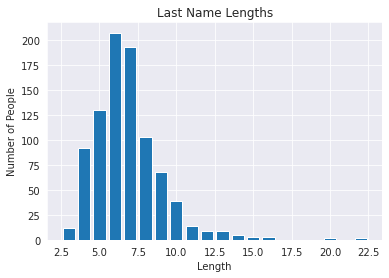

In [12]:
length = []
for i in range(len(train.Name)):
    end = train['Name'][i].find(',')
    length.append(end)

train['LastNameLength'] = length

counts = []
for i in sorted(list(train.LastNameLength.unique())):
    counts.append((train.LastNameLength == i).sum())
plt.bar(sorted(list(train.LastNameLength.unique())), height = counts)
plt.title('Last Name Lengths')
plt.xlabel('Length')
plt.ylabel('Number of People')

On the graph, we can see there are several outliers towards the 22 and 20 side, which we may have to disinclude or change later on. But as we can see, the bulk of people are centered around the 6-7 characters long.

Text(0, 0.5, 'Number of People')

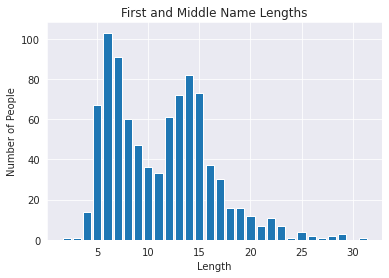

In [13]:
length = []
for i in range(len(train.Name)):
    beg = train['Name'][i].find('.')
    if '(' in train['Name'][i]:
        end = train['Name'][i].find('(')
        if (end-beg-3 < 0):
            close = train['Name'][i].find(')')
            length.append(close-end-1)
        else:
            length.append(end-beg-3)
    else:
        length.append(len(train['Name'][i]) - beg - 1)
        
train['FMNameLength'] = length


counts = []
for i in sorted(list(train.FMNameLength.unique())):
    counts.append((train.FMNameLength == i).sum())
plt.bar(sorted(list(train.FMNameLength.unique())), height = counts)
plt.title('First and Middle Name Lengths')
plt.xlabel('Length')
plt.ylabel('Number of People')

Different from the first graph, we can see two peaks in the graph, one around 6-7 nd the other around 14-15. This is an interesting trend that we will have to watch out for.

Text(0, 0.5, 'Number of People')

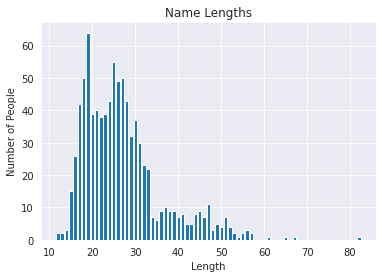

In [14]:
train['NameLength'] = train['Name'].apply(lambda x:len(x))

counts = []
for i in sorted(list(train.NameLength.unique())):
    counts.append((train.NameLength == i).sum())
plt.bar(sorted(list(train.NameLength.unique())), height = counts)
plt.title('Name Lengths')
plt.xlabel('Length')
plt.ylabel('Number of People')

Here, we see the same curvature, but a high peak around 17-18 and 25. We can the reoccuring double peak from the second graph, but also the overarching "close to" normal distribution from the first graph.

# **"Second Name"**

Another interesting feature that I noticed in the name feature was the presence of a "second name", which was denotated by the brackets. This may be an important feature, indicating either higher rank or greater prestige, so I will create a boolean feature to show whether or not this person has a "second name" or not.

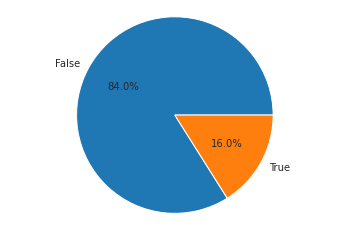

In [15]:
train['SecondName'] = train['Name'].apply(lambda x: True if '(' in x else False)

fig1, ax1 = plt.subplots()
sizes = []
for i in train.SecondName.unique():
    sizes.append((train.SecondName==i).sum())
ax1.pie(sizes, labels = train.SecondName.unique(),autopct = '%1.1f%%')
ax1.axis('equal')
plt.show()


In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Pclass_1,Pclass_2,Pclass_3,Titles,SpecialTitle,LastNameLength,FMNameLength,NameLength,SecondName
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,0,0,1,11,False,6,12,23,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,1,0,0,12,False,7,12,51,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,0,0,1,8,False,9,6,22,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,1,0,0,12,False,8,13,44,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,0,1,11,False,5,14,24,False


We can see that almost 16% of the people have a second name. Could be an important factor to consider down the road.

# **Sex**

For sex, there is not much we can probe from. The most we can do is assign categorical codes for it. From the pie chart though, it is interesting to see how most of the passengers were male. Maybe the less population of females affected how many of them survived.

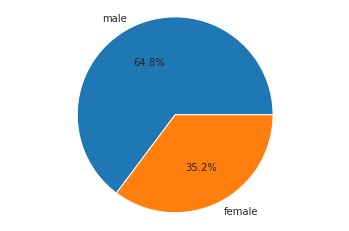

In [17]:
fig1, ax1 = plt.subplots()
sizes = []
for i in train.Sex.unique():
    sizes.append((train.Sex==i).sum())
ax1.pie(sizes, labels = train.Sex.unique(),autopct = '%1.1f%%')
ax1.axis('equal')
plt.show()

train['Sex'] = train['Sex'].astype('category').cat.codes

# **Age**

Age is another simple feature to handle, but we can defenitely find some special features from this. First, we have to remember that age had a lot of null features in it. We want to recognize which one of the age values were null, but at the same time we want to impute a value in so the classifier can learn from that feature. Therefore, we will create a separate "AgeNull" feature, which is a boolean feature showing whether or not the element was null. Next, I will impute the mean age into the NaN values, as that will be the best estimate that we can get.

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket     Fare  ... Pclass_1 Pclass_2  Pclass_3  Titles  \
0         A/5 21171   7.2500  ...        0        0         1      11   
1          PC 17599  71.2833  ...        1        0         0      12   
2  STON/O2. 3101282   7.9250  ...        0        0         1       8   
3   

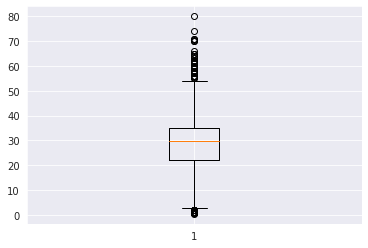

In [18]:
train['AgeNull'] = train['Age'].apply(lambda x: math.isnan(x))
train['Age'] = train['Age'].fillna(train['Age'].mean())

plt.boxplot(train.Age)

print(train.head(5))

The average age of the people seem to be around 30, but there are a lot of outliers, especially to the top. We defenitely should create a feature to recognize those outliers. Therefore, I will create three more features, separating the age groups into child, adult, and senior. On the Titantic, Senior and Children were given priority when it came to evacuation so it defenitely will be a useful feature to use in the training of this classifier.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Titles,SpecialTitle,LastNameLength,FMNameLength,NameLength,SecondName,AgeNull,Child,Adult,Senior
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,11,False,6,12,23,False,False,False,True,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,12,False,7,12,51,True,False,False,True,False
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,8,False,9,6,22,False,False,False,True,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,12,False,8,13,44,True,False,False,True,False
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,11,False,5,14,24,False,False,False,True,False


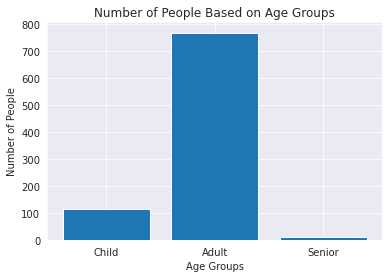

In [19]:
train['Child'] = train['Age'].apply(lambda x: True if x < 18 else False)
train['Adult'] = train['Age'].apply(lambda x: True if x >= 18 and x < 65 else False)
train['Senior'] = train['Age'].apply(lambda x: True if x >= 65 else False)

plt.bar(['Child','Adult','Senior'], height = [(train.Child == True).sum(), (train.Adult == True).sum(), (train.Senior == True).sum()])
plt.title('Number of People Based on Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Number of People')

train.head()

As we can see there are a lot more adults than there are seniors and children combined, which may be a good distinctive feature.

Finally, I will create an 'estimated age' feature. In the documentation of this data, it is stated that if the age ends in .5, the age was estimated. This will be another feature that we can extract that may prove to be useful in the future.

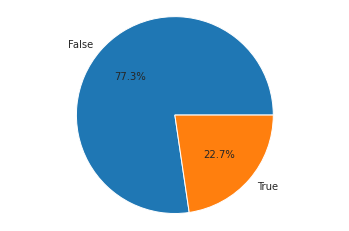

In [20]:
train['EstimatedAge'] = train['Age'].apply(lambda x: True if round(x) != x else False)

fig1, ax1 = plt.subplots()
sizes = []
for i in train.EstimatedAge.unique():
    sizes.append((train.EstimatedAge==i).sum())
ax1.pie(sizes, labels = train.EstimatedAge.unique(),autopct = '%1.1f%%')
ax1.axis('equal')
plt.show()

# **SibSp and Parch**

SibSp and Parch are two features that are closely interrelated. SibSp, representing siblings and spouses, and parch, representing parents and children, can be combined to find the total members of the family aboard the ship, disincluding themselves. Having less family members may increase the chances of survival because they don't have family to care for.

In [21]:
train['Family'] = train['SibSp'] + train['Parch']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,LastNameLength,FMNameLength,NameLength,SecondName,AgeNull,Child,Adult,Senior,EstimatedAge,Family
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,6,12,23,False,False,False,True,False,False,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,7,12,51,True,False,False,True,False,False,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,9,6,22,False,False,False,True,False,False,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,8,13,44,True,False,False,True,False,False,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,5,14,24,False,False,False,True,False,False,0


Text(0, 0.5, 'Number of People')

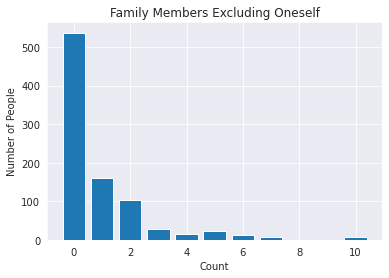

In [22]:
counts = []
for i in sorted(list(train.Family.unique())):
    counts.append((train.Family == i).sum())
plt.bar(sorted(list(train.Family.unique())), height = counts)
plt.title('Family Members Excluding Oneself')
plt.xlabel('Count')
plt.ylabel('Number of People')

As we can see the data is heavily skewed the right but there are some of those people who have large amounts of family members, such as that one person who has 10. These people may be less likely to survive, especailly if they are parents, in an attempt to save their children.

Let's analyze the SibSp and Parch data before we move on.

Text(0, 0.5, 'Number of People')

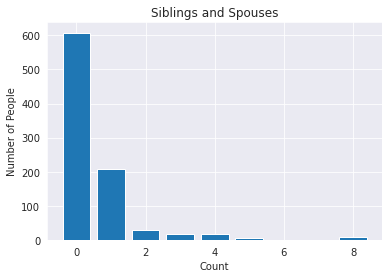

In [23]:
counts = []
for i in sorted(list(train.SibSp.unique())):
    counts.append((train.SibSp == i).sum())
plt.bar(sorted(list(train.SibSp.unique())), height = counts)
plt.title('Siblings and Spouses')
plt.xlabel('Count')
plt.ylabel('Number of People')

Text(0, 0.5, 'Number of People')

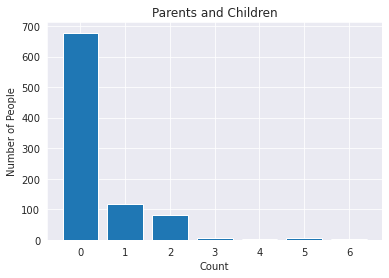

In [24]:
counts = []
for i in sorted(list(train.Parch.unique())):
    counts.append((train.Parch == i).sum())
plt.bar(sorted(list(train.Parch.unique())), height = counts)
plt.title('Parents and Children')
plt.xlabel('Count')
plt.ylabel('Number of People')

For both of these graphs, we can see a high percentage of people having 0 parents, children, spouses, or siblings. Therefore, these may not be the best discriminating factors. 

One last interesting feature I can create is from the documentation from the data. It stated how children who have parch as 0 may be travelling with a nanny. It would be helpful to identify these kids, as they may be more likely to be clueless to the events around them without a proper parent taking care of them.

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket     Fare  ... FMNameLength NameLength  SecondName  \
0         A/5 21171   7.2500  ...           12         23       False   
1          PC 17599  71.2833  ...           12         51        True   
2  STON/O2. 3101282   7.9250  ...            6         22       False   
3   

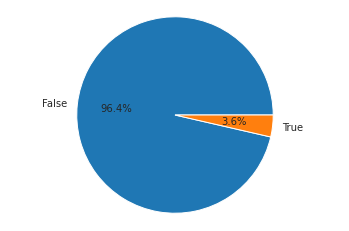

In [25]:
nanny = []
for i in range(0,len(train)):
    if (train['Parch'][i] ==0 and train['Age'][i] < 18):
        nanny.append(True)
    else:
        nanny.append(False)
train['Nanny'] = nanny

print(train.head())

fig1, ax1 = plt.subplots()
sizes = []
for i in train.Nanny.unique():
    sizes.append((train.Nanny==i).sum())
ax1.pie(sizes, labels = train.Nanny.unique(),autopct = '%1.1f%%')
ax1.axis('equal')
plt.show()

Seems like the percentages of this is very small and insignificant, but still could be an important factor.

# **Tickets**

Next we will take a look at tickets. This a more complicated feature because there are a lot of variation in the data and contains a combination of letters and numbers. This is defenitely going to one of the more complicated features we have to deal with.

In [26]:
train.Ticket[:5]

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

So as we can see the tickets may or may no have a prefix, with letters and then following it with numbers behind it. We want to split this into two separate features.

In [27]:
nums = []
prefix = []
for i in range(len(train.Ticket)):
    space = train['Ticket'][i].find(' ')
    if space != -1:
        prefix.append(train['Ticket'][i][:space])
    else:
        prefix.append('')
    if space != 0:
        nums.append(train['Ticket'][i][space+1:])
    else:
        nums.append(train['Ticket'][i])

print(nums[:5])

print(prefix[:5])

['21171', '17599', '3101282', '113803', '373450']
['A/5', 'PC', 'STON/O2.', '', '']


As you can see, we worked this out pretty nicely. But there is still a couple things we have to sort through. For the prefix list, there are a lot of very similar prefixs that could be due to spelling errors, such as A/5 vs A./5. I will combine all these by taking out all punctuation in the strings and then making them all uppercase. (Note: The '' denote that there are no prefixes in the string.)

In [28]:
punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
for pre in range (len(prefix)):
    for p in range (len(punc)):
        prefix[pre] = prefix[pre].replace(punc[p],'').upper()
        
prefix[:5]

['A5', 'PC', 'STONO2', '', '']

Now with the numbers, there were several glithces in our algorithm. These include the end of the prefixes containing 2, for example. These are things that I have to replace and turn the astype to an integer.

In [29]:
for i in range (len(nums)):
    if '2. ' in nums[i]:
        nums[i] = nums[i][3:]
train['TicketNum'] = nums
train['TicketNum'] = train['TicketNum'].replace({'2. 3101285': '3101285','Basle 541':'541','LINE':'0','2. 3101294':'3101294'})
train['TicketNum'] = train['TicketNum'].astype('int')

train['TicketPrefix'] = prefix
train['TicketPrefix'] = train['TicketPrefix'].astype('category').cat.codes

print(nums[:5])

['21171', '17599', '3101282', '113803', '373450']


Nice! Let's visualize the features we made so far.

Text(0, 0.5, 'Number of People')

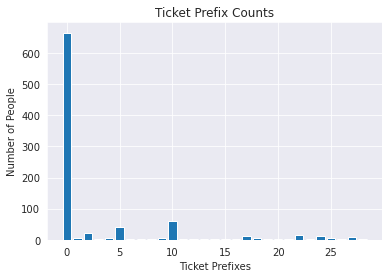

In [30]:
counts = []
for i in sorted(list(train.TicketPrefix.unique())):
    counts.append((train.TicketPrefix == i).sum())
plt.bar(sorted(list(train.TicketPrefix.unique())), height = counts)
plt.title('Ticket Prefix Counts')
plt.xlabel('Ticket Prefixes')
plt.ylabel('Number of People')

This may not be the best feature for us to use because most of the data is considered null (or 0). But there seems to be clustered around 5 and a little past 10, which could indicate similar types of people.

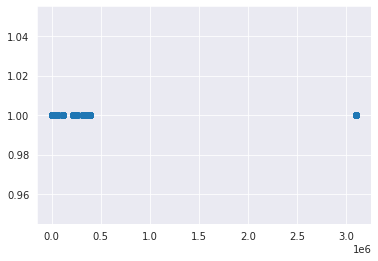

In [31]:
plt.scatter(train.TicketNum,np.ones(len(train)))

Again, we see a high density and frequency of values centered around 0 to 0.5, but there seems to be a couple outliers towards the 3.0 section. They may skew the data and affect the prediction accuracy so we may have to review it in the future.

# **Fare**

Finally! We have an easier feature to handle. Let's fill in the null values with the mode of the "Fares" feature and visualize the data.

Note 1: I am using the mode because typically, fares are set based on the ticket purchased, so there are many repeated values that would fit each fare.
Note 2: I am not making a separate "FareNull" because there are a very small number of null values (Less than 10), which makes the null fare column indiscriminat and unhelpful.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe6b8c7be50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe6b8c7e910>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe6b8c7b910>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe6b8c85410>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe6b8c85950>],
 'means': []}

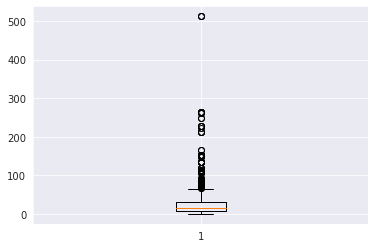

In [32]:
train['Fare'] = train['Fare'].fillna(train['Fare'].mode())

plt.boxplot(train.Fare)

We can see there is a large amount of outliers, especially the one above the 500 range. It may be helpful to separate the outliers from the normal values, but I will be skipping that for now.

# **Cabin**

Let's take a look at the "Cabin" feature. The Cabin feature is very similar to Ticket feature, in that it has a letter prefix and a number suffix. Good thing with the Cabin feature is that we know that the first character will be a letter. 

Let's fill all the null values (Since there is A LOT) with the letter 'Z'. There is no need to make another "null" value feature because the Cabin feature acts as a null value because the 'Z' acts this function. I will also create a "CabinLetter" feature by isolating the first character in the string.

In [33]:
train['Cabin'] = train['Cabin'].fillna('Z')
train['CabinLetter'] = train['Cabin'].apply(lambda x: x[0])

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,AgeNull,Child,Adult,Senior,EstimatedAge,Family,Nanny,TicketNum,TicketPrefix,CabinLetter
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,False,False,True,False,False,1,False,21171,2,Z
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,False,False,True,False,False,1,False,17599,10,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,False,False,True,False,False,0,False,3101282,25,Z
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,False,False,True,False,False,1,False,113803,0,C
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,False,False,True,False,False,0,False,373450,0,Z


I will also isolate the number value of the "Cabin" feature. I have to make sure to distinguish the 'Z' values from the actual number values to make sure we isolate the null values. 

In [34]:
nums = []
for i in range (0,len(train['Cabin'])):
    end = 0
    for j in range (1,len(train['Cabin'][i])+1):
        if (train['Cabin'][i][-j].isalpha()):
            end = j-1
            break
    nums.append(train['Cabin'][i][-end:])
train['CabinNum'] = nums
train['CabinNum'] = train['CabinNum'].replace({'':'0','Z':'0','D':'0','T':'0'})
train['CabinNum'] = train['CabinNum'].astype(int)


train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Child,Adult,Senior,EstimatedAge,Family,Nanny,TicketNum,TicketPrefix,CabinLetter,CabinNum
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,False,True,False,False,1,False,21171,2,Z,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,False,True,False,False,1,False,17599,10,C,85
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,False,True,False,False,0,False,3101282,25,Z,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,False,True,False,False,1,False,113803,0,C,123
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,False,True,False,False,0,False,373450,0,Z,0


Let's visualize the Cabin Number distribution of the data.

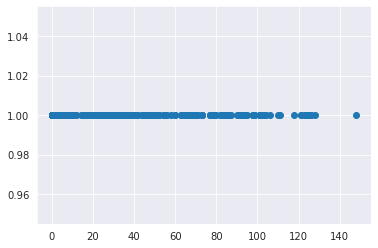

In [35]:
plt.scatter(train.CabinNum,np.ones(len(train)))
plt.show()

We can see a decently spread out distribution of the Cabin Numbers from the dataset. This may indicate that there is a wide variety of variations in the numbers and may be a strong classification point. Also the location of the Cabin may actually have a huge impact on the probability of the person surviving.

Let's also visualize the count of each prefix in a bar graph. 

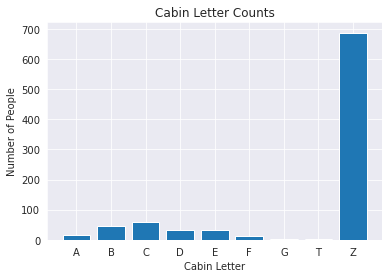

In [36]:
counts = []
for i in sorted(list(train.CabinLetter.unique())):
    counts.append((train.CabinLetter == i).sum())
plt.bar(sorted(list(train.CabinLetter.unique())), height = counts)
plt.title('Cabin Letter Counts')
plt.xlabel('Cabin Letter')
plt.ylabel('Number of People')

train['CabinLetter'] = train['CabinLetter'].astype('category').cat.codes

Obviously, we see a huge distribution of 'Z' values, representing the null values. There is also almost a normal distribution of values from A-T, maybe representing the differently parts of layers of the ship, which could also affect whether or not the passenger survives.

# **Embarked**

Finally, the last feature we have to tackle is the "embarked" feature. There is not much we can separate here, as there clearly are three destinations that the Titantic ported at. Therefore, I will fill in the missing features in Embarked (which is also a very small amount) and one-hot encode the data.

In [37]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode())
embarked = pd.get_dummies(train.Embarked, prefix = 'Emb')
train = pd.concat([train,embarked],axis = 1)
train = train.drop(['Embarked'],axis = 1)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,EstimatedAge,Family,Nanny,TicketNum,TicketPrefix,CabinLetter,CabinNum,Emb_C,Emb_Q,Emb_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,False,1,False,21171,2,8,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,False,1,False,17599,10,2,85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,False,0,False,3101282,25,8,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,False,1,False,113803,0,2,123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,False,0,False,373450,0,8,0,0,0,1


Let's quickly visualize the data before wrapping up. 

<BarContainer object of 3 artists>

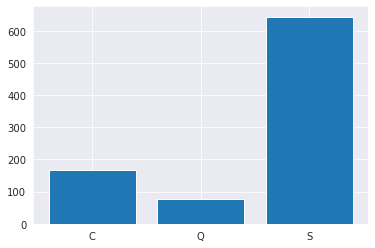

In [38]:
plt.bar(['C','Q','S'],[(train.Emb_C == 1).sum(),(train.Emb_Q == 1).sum(),(train.Emb_S == 1).sum()])

We can see a high percentage of people coming from the 'S' dock. Regardless though, where you dock from should not really affect whether you survive or not, unless people who come from similar ports have similar tendencies in the places on the ship they visit.

And that's all the features! Whew that took a lot of work. Hopefully you found this helpful for you to try out new features in your code. Please remember to comment any questions, concerns, or mistakes that you see and please upvote if you found this helpful! Remember that if you want to check out how these features improved predictions.